Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
(256, 256, 3) (256, 256, 3) (256, 256, 3) (256, 256, 3)


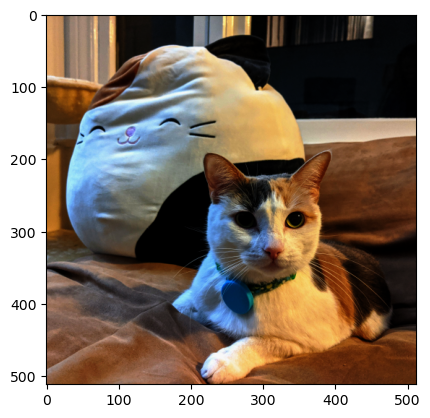

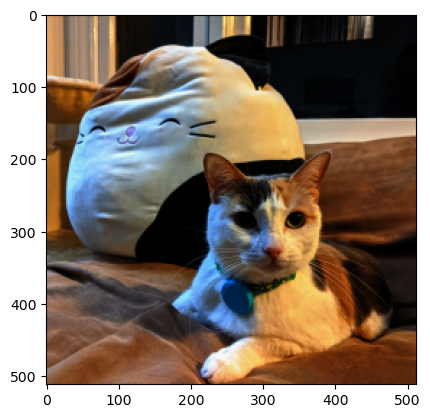

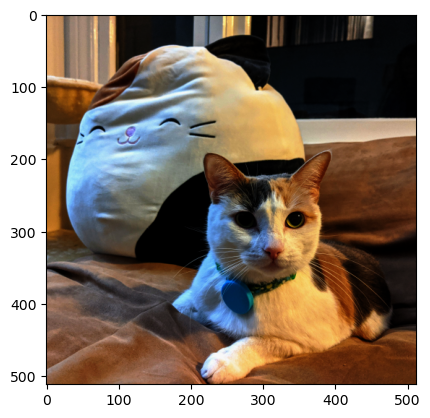

In [2]:
import pywt
import ps_lib as ps
import scipy
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt


img_path = "target-image.png"
img = ps.read_image(img_path)
print(img.shape)
LL, (LH, HL, HH) = pywt.dwt2(img, 'haar', axes = (0, 1))

img_recover = pywt.idwt2((LL, (LH, HL, HH)), 'haar', axes = (0, 1))

print(LL.shape, LH.shape, HL.shape, HH.shape)
plt.imshow(img_recover)
plt.show()
plt.imshow(pywt.idwt2((LL, (None, None, None)), 'haar', axes = (0, 1)))
plt.show()
# Image recovered from the inverse idwt
plt.imshow(img)
plt.show()


Quantizing Step

In [3]:




img_path = "target-image.png"
img = ps.read_image(img_path)

# Decompose the image into luminence, color channels
img = 255 * img

R = img[:, :, 0]
G = img[:, :, 1]
B = img[:, :, 2]
y  = .299 * R + .587*G + .114*B
# cb = 128 + .168736 * R -.331264 * G + .5 * B
# cr = 128 + .5 * R -.418688 * G - .081312*B

# new_img = np.dstack([y, cb, cr]) / 255 
new_img = np.dstack([R, G, B]) / 255 
print(np.max(new_img), np.min(new_img))

coeff = scipy.fftpack.dct(scipy.fftpack.dct(new_img, axis=0, norm='ortho'), axis=1, norm='ortho')
print(coeff.shape)

# quantizing the coefficients


1.0 0.0
(512, 512, 3)


In [ ]:
def get_dct_coeff(img):
    dct_coeffs = np.zeros(img.shape)

    for i in range(8):
        for j in range(8):
            T = [.3536, .3536, .3536, .3536, .3536, .3536, .3536, .3536, .4904, .4157, .2778, .0975, -.0975, -.2778, -.4157, -.4904, .4619, .1913, -.1913, -.4619, -.4619, -.1913, .1913, .4619, .4157, -.0975, -.4904, -.2778, .2778, .4904, .0975, -.4157, .3536, -.3536, -.3536, .3536, .3536, -.3536, -.3536, .3536, .2778, -.4904, .0975, .4157, -.4157, -.0975, .4904, -.2778, .1913, -.4619, .4619, -.1913, -.1913, .4619, -.4619, .1913, .0975, -.2778, .4157, -.4904, .4904, -.4157, .2778, -.0975]

            T = np.reshape(T, (8,8))

            M = [26, -5, -5, -5, -5, -5, -5, 8, 64, 52, 8, 26, 26, 26, 8, -18, 126, 70, 26, 26, 52, 26, -5, -5, 111, 52, 8, 52, 52, 38, -5, -5, 52, 26, 8, 39, 38, 21, 8, 8, 0, 8, -5, 8, 26, 52, 70, 26, -5, -23, -18, 21, 8, 8, 52, 38, -18, 8, -5, -5, -5, 8, 26, 8]
            M = np.reshape(M, (8,8))
            # matrix = np.array(data).reshape(8, 8) / 255

            D = np.round(np.array(T @ M @ T.T), 1)
            print(D.shape)
            dct_coeffs[i:i+8, j:j+8] = D        
    return dct_coeffs

def quantize_img(dct_coeffs):
    q_mat=np.array([[16,11,10,16,24,40,51,61],
                    [12,12,14,19,26,58,60,55],
                    [14,13,16,24,40,57,69,56],
                    [14,17,22,29,51,87,80,62],
                    [18,22,37,56,68,109,103,77],
                    [24,35,55,64,81,104,113,92],
                    [49,64,78,87,103,121,120,101],
                    [72,92,95,98,112,100,103,99]])
    img_quantized = np.zeros(dct_coeffs.shape)
    for i in range(dct_coeffs.shape[0]):
        for j in range(dct_coeffs.shape[1]):
            D = dct_coeffs[i:i+8, j:j+8]
            c = np.floor(np.array(D / q_mat)).astype(np.int8)
            img_quantized[i:i+8, j:j+8] = c
    print(c)
    return img_quantized


In [4]:
import numpy as np

original_data = [154, 123, 123, 123, 123, 123, 123, 136, 192, 180, 136, 154, 154, 154, 136, 110, 254, 198, 154, 154, 180, 154, 123, 123, 239, 180, 136, 180, 180, 166, 123, 123, 180, 154, 136, 167, 166, 149, 136, 136, 128, 136, 123, 136, 154, 180, 198, 154, 123, 105, 110, 149, 136, 136, 180, 166, 110, 136, 123, 123, 123, 136, 154, 136]

original_data = np.array(original_data).reshape((8, 8))



data = np.array(original_data).reshape((8, 8)) - 128


# Define quantization matrix for Qfactor of 50
q_mat=np.array([[16,11,10,16,24,40,51,61],
                [12,12,14,19,26,58,60,55],
                [14,13,16,24,40,57,69,56],
                [14,17,22,29,51,87,80,62],
                [18,22,37,56,68,109,103,77],
                [24,35,55,64,81,104,113,92],
                [49,64,78,87,103,121,120,101],
                [72,92,95,98,112,100,103,99]])

c = np.round(np.array(D / q_mat)).astype(np.int8)
print(c)


[[162.3  40.6  20.   72.3  30.3  12.5 -19.7 -11.5]
 [ 30.5 108.4  10.5  32.3  27.7 -15.5  18.4  -2. ]
 [-94.1 -60.   12.3 -43.4 -31.3   6.1  -3.3   7.1]
 [-38.6 -83.4  -5.4 -22.2 -13.5  15.5  -1.3   3.5]
 [-31.3  17.9  -5.5 -12.4  14.3  -6.   11.5  -6. ]
 [ -0.9 -11.8  12.8   0.2  28.1  12.6   8.4   2.9]
 [  4.6  -2.4  12.2   6.6 -18.7 -12.8   7.7  12. ]
 [-10.   11.2   7.8 -16.3  21.5   0.    5.9  10.7]]
[[10  4  2  5  1  0  0  0]
 [ 3  9  1  2  1  0  0  0]
 [-7 -5  1 -2 -1  0  0  0]
 [-3 -5  0 -1  0  0  0  0]
 [-2  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


# decompression


In [5]:
r = q_mat * c
N = np.round(T.T @ r @ T) + 128
print(N)

[[149. 134. 119. 116. 121. 126. 127. 128.]
 [204. 168. 140. 144. 155. 150. 135. 125.]
 [253. 195. 155. 166. 183. 165. 131. 111.]
 [245. 185. 148. 166. 184. 160. 124. 107.]
 [188. 149. 132. 155. 172. 159. 141. 136.]
 [132. 123. 125. 143. 160. 166. 168. 171.]
 [109. 119. 126. 128. 139. 158. 168. 166.]
 [111. 127. 127. 114. 118. 141. 147. 135.]]


# JPEG the image

In [6]:
# img_path = "target-image.png"
# img = ps.read_image(img_path)
# print(img.shape)

# for i in range(0, img.shape[0], 8):
#     for j in range(0, img.shape[0], 8):
        

# LL, (LH, HL, HH) = pywt.dwt2(img, 'haar', axes = (0, 1))

# img_recover = pywt.idwt2((LL, (LH, HL, HH)), 'haar', axes = (0, 1))

# print(LL.shape)
# plt.imshow(img_recover)
# plt.show()

# plt.imshow(img)
# plt.show()
# plt.imshow(LH)
# plt.show()
# plt.imshow(LL)
# plt.show()
# plt.imshow(HH)
# plt.show()

IndentationError: expected an indented block (1721475157.py, line 13)

# JPEG Dimple

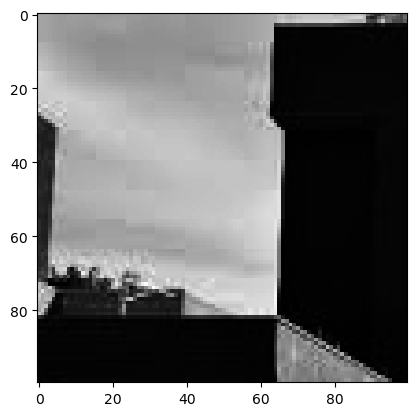

In [29]:
img_path = "images.jpg"
img = ps.read_image(img_path)
R = img[:, :, 0]
G = img[:, :, 1]
B = img[:, :, 2]
y  = .299 * R + .587*G + .114*B
plt.imshow(y[:100, :100], cmap='gray')

In [30]:
img.shape

(183, 275, 3)

In [64]:
from scipy.signal import correlate2d
from scipy.ndimage import correlate
from scipy.signal import wiener

def create_template(img_shape):
    template = np.zeros(img_shape)
    template[::8, ::8] = 1
    return template

def compute_pce(img, template):
    # ndimage is a lot faster than correlate2d????
    fi = correlate(img, template)
    max_corr = np.max(fi)
    u_hat, v_hat = np.unravel_index(np.argmax(fi), fi.shape)
    
    # Calculate the correlation energy excluding the peak
    energy = np.sum(fi**2) - max_corr**2
    
    # PCE calculation
    pce = max_corr**2 / (energy / (fi.size - 1))
    
    return pce

In [69]:
img_path = "images.jpg"
img = ps.read_image(img_path)
R = img[:, :, 0]
G = img[:, :, 1]
B = img[:, :, 2]
y  = .299 * R + .587*G + .114*B

template = create_template(y.shape)
pce = compute_pce(y, template)
print(pce)


3.4611495585307295


In [66]:
# apply a 3 × 3 Wiener filter to each
# RGB channel and average the resulting noise residual across
# all three channels.

def compute_noise_residual(image):
    noise_residuals = []
    for i in range(3):  # Assuming the image is in RGB format
        channel = image[:, :, i]
        filtered_channel = wiener(channel, (3, 3))
        noise_residual = channel - filtered_channel
        noise_residuals.append(noise_residual)
    
    # Average the noise residuals across the three channels
    avg_noise_residual = np.mean(noise_residuals, axis=0)

    return avg_noise_residual

def average_blocks(image, block_size=32):
    height, width = image.shape
    avg_blocks = np.zeros((height // block_size + 1, width // block_size + 1))
    print(avg_blocks.shape)
    
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = image[i:i + block_size, j:j + block_size]
            avg_blocks[i // block_size, j // block_size] = np.mean(block)
    
    return avg_blocks    

# To further suppress image content, nonoverlapping blocks of size 32 × 32 are then averaged across
# the entire image (or, optionally, a portion of the image). The
# PCE is then computed against this averaged 32×32 block and
# the corresponding template of the same size.

In [70]:
def create_per_pixel_prominence_map(image, template, window_size=128):
    height, width = image.shape
    prominence_map = np.zeros((height, width))
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # define the window 
            window_row_start = max(0, i - window_size // 2)
            window_row_end = min(image.shape[0], i + window_size // 2)
            window_col_start = max(0, j - window_size // 2)
            window_col_end = min(image.shape[1], j + window_size // 2)
            
            window = image[window_row_start:window_row_end, window_col_start:window_col_end]
            
            pce_value = compute_pce(window, template)
            
            # Assign the average PCE to the prominence map
            prominence_map[i, j] = pce_value
        print(i)
    return prominence_map
template = create_template((32, 32))
prominence_map = create_per_pixel_prominence_map(y, template)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182


In [71]:
print(prominence_map)

[[1.45282351 1.50126942 1.52530048 ... 1.24763838 1.24949536 1.25147406]
 [1.44657485 1.49346467 1.51729461 ... 1.24306248 1.24484414 1.24674927]
 [1.43859161 1.48533508 1.51317655 ... 1.2388935  1.24060241 1.24243094]
 ...
 [3.58613022 3.58088025 3.57545672 ... 6.51351359 6.54413612 6.60941702]
 [3.533326   3.52814448 3.52280846 ... 6.40704185 6.44256446 6.50835307]
 [3.48066403 3.47555262 3.47029236 ... 6.25743531 6.2907124  6.35891417]]


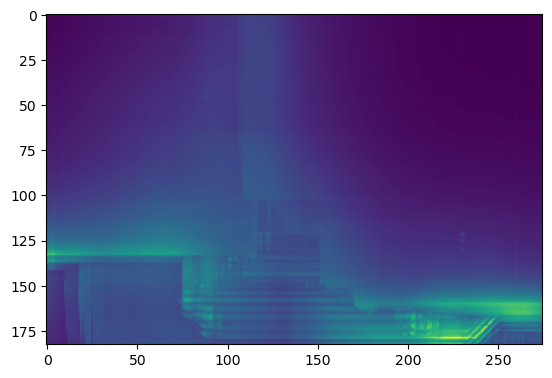

In [72]:
plt.imshow(prominence_map)

# JPEG 2000 stuff

# Computing the DWT

In [ ]:
H = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, -1, -1, -1, -1],
    [1, 1, -1, -1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, -1, -1],
    [1, -1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, -1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, -1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, -1]
]).T


# H = np.array([])

# Normalize the matrix
norm = np.linalg.det(H)
# print(row_norms)
col_norms = np.linalg.norm(H, axis=0, keepdims=True)
# print(col_norms)
np.set_printoptions(precision=3, suppress=True)
print(H)
normalized_H = H / norm

# print(normalized_H)
row = data[0]
bruh = normalized_H @ np.array(row)
print(bruh)

# print(row)
# print(discrete_haar_wavelet_transform(row.copy()))
# print(row)
# print(row)

# approximation = np.array(two_dimensional_haar_wavelet_transform(y / 255))
# print(approximation)
# plt.imshow(approximation)
# plt.show()
# plt.imshow(y)
# plt.show()


[[ 1  1  1  0  1  0  0  0]
 [ 1  1  1  0 -1  0  0  0]
 [ 1  1 -1  0  0  1  0  0]
 [ 1  1 -1  0  0 -1  0  0]
 [ 1 -1  0  1  0  0  1  0]
 [ 1 -1  0  1  0  0 -1  0]
 [ 1 -1  0 -1  0  0  0  1]
 [ 1 -1  0 -1  0  0  0 -1]]
[0.086 0.164 0.164 0.242 0.164 0.242 0.344 0.219]


In [ ]:
H = [[.5, .5, 0, 0, 0, 0, 0, 0], [.5, -.5, 0, 0, 0, 0, 0, 0], [0, 0, .5, .5, 0, 0, 0, 0], [0, 0, .5, -.5, 0, 0, 0, 0], [0, 0, 0, 0, .5, .5, 0, 0], [0, 0, 0, 0, .5, -.5, 0, 0], [0, 0, 0, 0, 0, 0, .5, .5], [0, 0, 0, 0, 0, 0, .5, -.5]]
H = np.reshape(H, (8, 8))
norm_factor = np.linalg.norm(H, axis=1)
H = H / norm_factor
print(H)


print(H @ row)
print(pywt.dwt(row, 'haar'))

[[ 0.707  0.707  0.     0.     0.     0.     0.     0.   ]
 [ 0.707 -0.707  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.707  0.707  0.     0.     0.     0.   ]
 [ 0.     0.     0.707 -0.707  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.707  0.707  0.     0.   ]
 [ 0.     0.     0.     0.     0.707 -0.707  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.707  0.707]
 [ 0.     0.     0.     0.     0.     0.     0.707 -0.707]]
[14.849 21.92  -7.071  0.    -7.071  0.     2.121 -9.192]
(array([14.849, -7.071, -7.071,  2.121]), array([21.92 ,  0.   ,  0.   , -9.192]))


In [ ]:
H = np.array([[.5, .5, 0, 0], [.5, -.5, 0, 0], [0, 0, .5, .5], [0, 0, .5, -.5]])
print(H @ np.array([1, 3, 3, 4]) * np.sqrt(2))

[ 2.828 -1.414  4.95  -0.707]


In [ ]:
print(pywt.dwt([1, 2], 'db1'))


(array([2.121]), array([-0.707]))


# 2D wavelet transform

In [ ]:
def gen_harr_matrix(N: int):
    if N <= 1 or  (N & (N - 1)) != 0:
        print("N is not a multiple of 2 zodie")
        return
    
    harr = np.zeros((N, N))
    for i in range(0, N, 2):
        harr[i, i:i+2] = [1, 1]
        harr[i+1, i:i+2] = [1, -1]

    # normalizing the harr matrix so it's consistent with pwt
    return harr / np.linalg.norm(harr, axis=1)

def gen_harr_inverse(N: int):
    return np.linalg.inv(gen_harr_matrix(N))




In [ ]:
zodie = np.random.randint(0, 100, size=(512, 512)) # np.array([[1,3, 1, 52], [1,3, 133, 2], [9,56, 32, 1], [1,30, 10, 57]])


def get_2d_wavelet_transform(data):
    H = gen_harr_matrix(len(data))

    row_stuff = H @ data

    # permute the rowwws

    cA_row, cD_row = row_stuff[::2, :], row_stuff[1::2, :]
    # print(cA, '\n\n',cD)
    col_stuff = H @ cA_row.T

    cA, cV = col_stuff[::2, :].T, col_stuff[1::2, :].T
    col_stuff2 = H @ cD_row.T


    cH, cD = col_stuff2[::2, :].T, col_stuff2[1::2, :].T


    # cA_pywt, (cH_pywt, cV_pywt, cD_pywt) = pywt.dwt2(data, 'haar', axes =(0, 1))

    # assert len(np.flatnonzero(~np.isclose(cA, cA_pywt))) == 0
    # assert len(np.flatnonzero(~np.isclose(cH, cH_pywt))) == 0
    # assert len(np.flatnonzero(~np.isclose(cV, cV_pywt))) == 0
    # assert len(np.flatnonzero(~np.isclose(cD, cD_pywt))) == 0
    # assert len(np.flatnonzero(cV - cV_pywt)) == 0
    # assert len(np.flatnonzero(cD - cD_pywt)) == 0
    # assert len(np.flatnonzero(cH - cH_pywt)) == 0

    return cA, (cH, cV, cD)

cA, (cH, cV, cD) = get_2d_wavelet_transform(zodie)

def get_inv_wavelet_transform(cA, cH, cV, cD):
    h_inv = gen_harr_inverse(len(cA) * 2)
    print(cH.shape)
    col_stuff2 = np.zeros_like(np.vstack([cH, cH]))
    col_stuff2[::2, :] = cH.T
    col_stuff2[1::2, :] = cD.T

    cD_row = (h_inv @ col_stuff2).T


    col_stuff = np.zeros((cH.shape[0]*2, cH.shape[1]))
    col_stuff[::2, :] = cA.T
    col_stuff[1::2, :] = cV.T

    cA_row = (h_inv @ col_stuff).T

    row_stuff = np.zeros_like(np.vstack([cA_row, cA_row]))
    row_stuff[::2, :] = cA_row
    row_stuff[1::2, :] = cD_row
    
    data = h_inv @ row_stuff
    return data


assert len(np.flatnonzero(~np.isclose(zodie, get_inv_wavelet_transform(cA, cH, cV, cD)))) == 0

(256, 256)


# JPEG 2000 the image

In [ ]:
bruh = np.zeros((242, 241, 2)).T
print(bruh.shape)

(2, 241, 242)


In [ ]:
def quantize(R, i, c, f, blocks):
    base_step = 2 ** (R - c + i) * (1 + f/2**11)
    print(base_step)
    blur = blocks['blur']
    print(len(blur.flatten()))
    d = base_step / 32
    print(d)
    blur_quantize = np.sign(blur) * np.floor(np.abs(blur) / (d))
    # print(np.nonzero(blur_quantize))
    print(len(np.flatnonzero(blur_quantize)))
    
    return blur_quantize

def undo_quantize_blur(R, i, c, f, quantized_blur):
    base_step = 2 ** (R - c + i) * (1 + f/2**11)
    d = base_step / 32

    return quantized_blur * d


# quantize(8, 3, 8.5, 8, blocks)

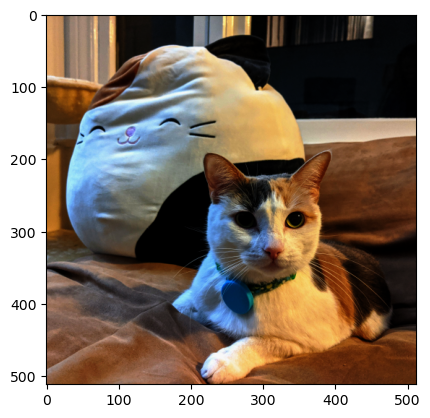

In [ ]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
1
2
0
1
2
0
1
2


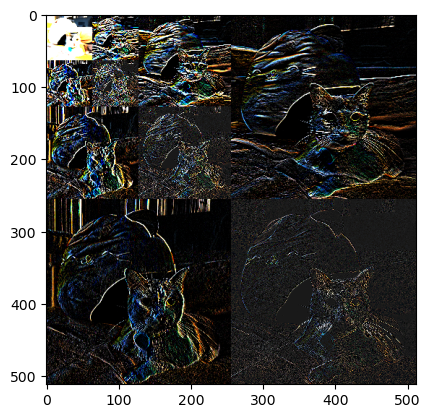

In [ ]:
def multiple_wavelet(img, iterations):
    blur = img
    blocks = {}
    for curr_iter in range(iterations):
        cAs = np.zeros((blur.shape[0] //2, blur.shape[0] //2 , 3))
        cHs = np.zeros((blur.shape[0] //2, blur.shape[0] //2 , 3))
        cVs = np.zeros((blur.shape[0] //2, blur.shape[0] //2 , 3))
        cDs = np.zeros((blur.shape[0] //2, blur.shape[0] //2 , 3))
        for i in range(3):
            print(i)
            cA, (cH, cV, cD) = pywt.dwt2(blur[:, :, i], 'haar') #get_2d_wavelet_transform(blur[:, :, i])
            cAs[:, :, i] = cA
            cHs[:, :, i] = cH
            cVs[:, :, i] = cV
            cDs[:, :, i] = cD

        blocks[str(curr_iter)] = {}
        blocks[str(curr_iter)]['cHs'] = cHs
        blocks[str(curr_iter)]['cVs'] = cVs
        blocks[str(curr_iter)]['cDs'] = cDs
        blocks[str(curr_iter)]['cAs'] = cAs
        
        blur = cAs
    blocks['blur'] = blur
    blocks['iterations'] = iterations
    return blocks

img_path = "target-image.png"
img = np.array(ps.read_image(img_path))

blocks = multiple_wavelet(img, 3)

# do the beautiful reconstruction thingy

wavelet_domain_img = np.zeros(img.shape)
# wavelet_domain_img[img.shape[0] // 2**2: 2*img.shape[0] // 2**2, img.shape[0] // 2**2: 2*img.shape[0] // 2**2, : ] = blocks['1']['cAs']

for i in range(blocks['iterations']):

    wavelet_domain_img[img.shape[0] // 2**(i + 1): 2*img.shape[0] // 2**(i + 1), img.shape[0] // 2**(i + 1): 2*img.shape[0] // 2**(i + 1), : ] = (blocks[str(i)]['cDs']+.01) * 10

    wavelet_domain_img[: img.shape[0] // 2**(i + 1), img.shape[0] // 2**(i + 1): 2*img.shape[0] // 2**(i + 1), : ] = blocks[str(i)]['cHs']* 10
    
    wavelet_domain_img[img.shape[0] // 2**(i + 1): 2*img.shape[0] // 2**(i + 1), 0: img.shape[0] // 2**(i + 1), : ] = blocks[str(i)]['cVs']* 10
wavelet_domain_img[:img.shape[0] // 2**(i + 1), :img.shape[0] // 2**(i + 1), : ] = blocks['blur']
plt.imshow(wavelet_domain_img)
plt.show()

5.67895133640446
12288
0.1774672292626394
11101


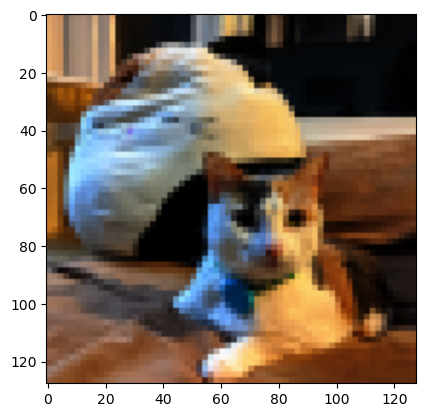

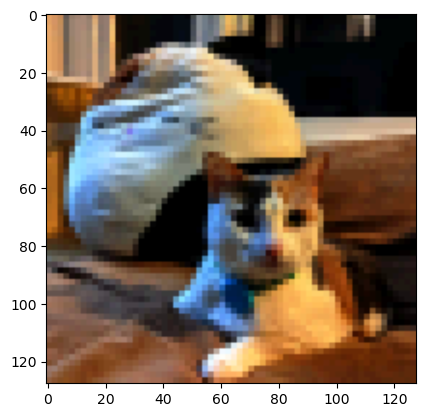

In [ ]:
blur = blocks['blur']
quantized_blur = quantize(8, 3, 8.5, 8, blocks)
zero = np.zeros(blur.shape)


# Set the detail coefficients of the higher levels to None to keep only low-frequency components

low_res_image_actual = pywt.idwt2([blur, (zero, zero, zero)], 'haar', axes=(0, 1))

recovered = undo_quantize_blur(8, 3, 8.5, 8,quantized_blur)
plt.imshow((low_res_image_actual - np.min(low_res_image_actual)) / (np.max(low_res_image_actual) - np.min(low_res_image_actual)))

plt.show()
low_res_image_recovered = pywt.idwt2([recovered, (zero, zero, zero)], 'haar', axes=(0, 1))

plt.imshow((low_res_image_recovered - np.min(low_res_image_recovered)) / (np.max(low_res_image_recovered) - np.min(low_res_image_recovered)))
plt.show()

zodie = (low_res_image_recovered - np.min(low_res_image_recovered)) / (np.max(low_res_image_recovered) - np.min(low_res_image_recovered))
ps.write_image("letsgooo.png", zodie)

zodie2 = (low_res_image_actual - np.min(low_res_image_actual)) / (np.max(low_res_image_actual) - np.min(low_res_image_actual))
ps.write_image("letsgooo2.png", zodie2)

# plt.imshow(blur)
# plt.show()

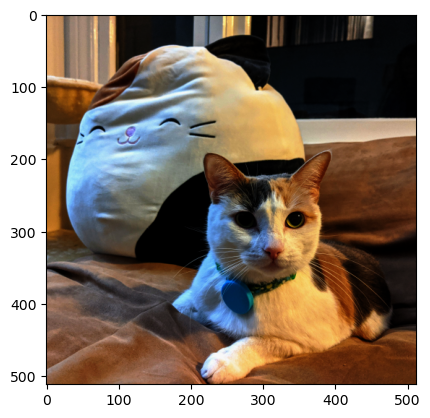

In [ ]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


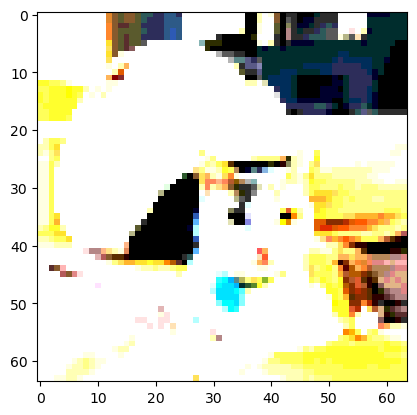

In [ ]:
plt.imshow(recovered)


7.6310908582934935
0.0


(array([3355., 1195., 1331., 1869., 1162., 1037.,  878.,  532.,  412.,
         517.]),
 array([0.   , 0.763, 1.526, 2.289, 3.052, 3.816, 4.579, 5.342, 6.105,
        6.868, 7.631]),
 <BarContainer object of 10 artists>)

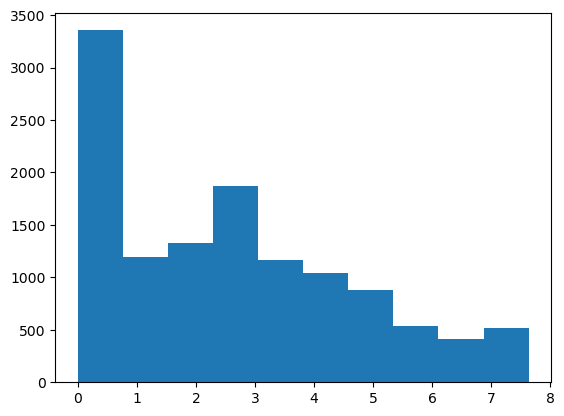

In [ ]:
print(np.max(recovered))
print(np.min(recovered))

plt.hist(recovered.flatten())

In [ ]:
blocks['0']['cHs'].shape

(256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


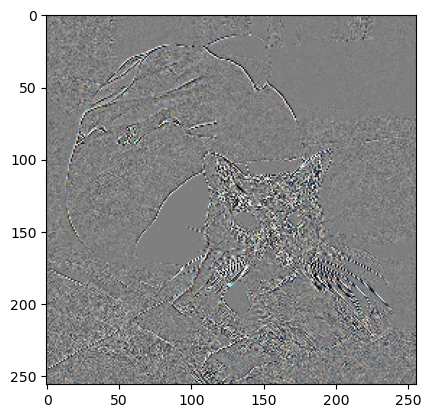

In [ ]:
plt.imshow((blocks['0']['cDs']+.05) * 10)

In [ ]:
blocks['0']['cDs'].shape

(256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256)
(256, 256)
(256, 256)


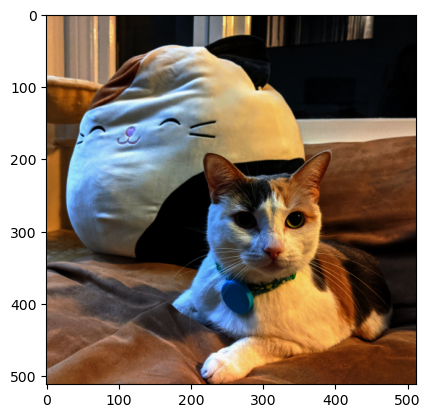

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


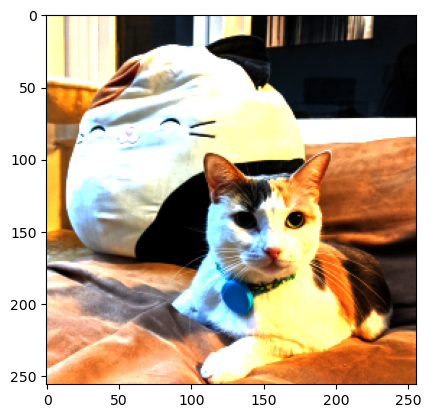

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


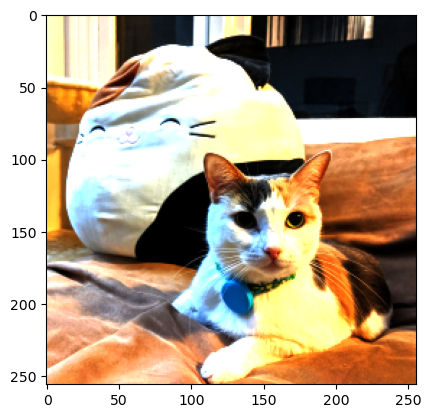

In [ ]:
img_path = "target-image.png"
img = np.array(ps.read_image(img_path))

cAs = np.zeros((img.shape[0] //2, img.shape[0] //2 , 3))
cHs = np.zeros((img.shape[0] //2, img.shape[0] //2 , 3))
cVs = np.zeros((img.shape[0] //2, img.shape[0] //2 , 3))
cDs = np.zeros((img.shape[0] //2, img.shape[0] //2 , 3))

for i in range(3):
    cA, (cH, cV, cD) = get_2d_wavelet_transform(img[:, :, i])
    cAs[:, :, i] = cA
    cHs[:, :, i] = cH
    cVs[:, :, i] = cV
    cDs[:, :, i] = cD

reconstructed_img = np.zeros(img.shape)
for i in range(3):
    reconstructed_img[:, :, i] = get_inv_wavelet_transform(cAs[:, :, i], cHs[:, :, i], cVs[:, :, i], cDs[:, :, i])

plt.imshow(reconstructed_img)
plt.show()


cA, (cH, cV, cD) =pywt.dwt2(img, 'haar', axes=(0,1))
plt.imshow(cA)
plt.show()
plt.imshow(cAs)
plt.show()


In [ ]:
cnt = 0
for i in range(512):
    for j in range(512):
        for k in range(3):
            cnt += 1

In [ ]:
zodie = np.array([[1,3], [2, 3]])
print(zodie, '\n')

H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
# norm_factor = np.linalg.norm(H, axis=1)
# print(norm_factor)


# multiplying zodie by transpose gives
# har wavelets in terms f 
print(H @ zodie)

print(pywt.dwt(zodie, 'db1', axis=0))


[[1 3]
 [2 3]] 

[[ 2.121  4.243]
 [-0.707  0.   ]]
(array([[2.121, 4.243]]), array([[-0.707,  0.   ]]))


In [ ]:
# doing it ourselves

zodie = np.array([[1,3], [2, 3]])

H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
# axis zero
# print(H @ zodie)
row_cA, row_cD = H @ zodie
print(row_cA, row_cD)

col_cA, col_cD = H @ row_cA.T 
print(col_cA, col_cD)


col_cA, col_cD = H @ row_cD.T 
print(col_cA, col_cD)

# LL, (cDh, cd)
print(pywt.dwt2(zodie, 'db1'))


[2.121 4.243] [-0.707  0.   ]
4.499999999999999 -1.4999999999999998
-0.4999999999999999 -0.4999999999999999
(array([[4.5]]), (array([[-0.5]]), array([[-1.5]]), array([[-0.5]])))


In [ ]:
# zodie = np.array([[151, 123], [566, 122]])




row_cA, row_cD = pywt.dwt(zodie, 'db1', axis=0)
# downsample, keep even index cols
# brodie = np.row_stack([row_cA, row_cD])
print(row_cA, row_cD,'\n')

col_cA, col_cD = pywt.dwt(row_cA, 'db1', axis=1)
# brodie = np.column_stack([row_cA, col_cD])[::2, :]
print(col_cA, col_cD)

print("yooooo\n\n")
cols_cA, cols_cD = pywt.dwt(row_cD, 'db1', axis=1)
print(cols_cA, cols_cD)


print(pywt.dwt2(zodie, 'db1'))



[[2.121 4.243]] [[-0.707  0.   ]] 

[[4.5]] [[-1.5]]
yooooo


[[-0.5]] [[-0.5]]
(array([[4.5]]), (array([[-0.5]]), array([[-1.5]]), array([[-0.5]])))


In [ ]:
print(pywt.dwt(np.array([1,3,3,4]).T, 'db1'))

H = [.5, .5, .5, .5, .5, .5, -.5, -.5, np.sqrt(2)/2, -np.sqrt(2)/2, 0, 0, 0, 0, np.sqrt(2)/2, -np.sqrt(2)/2]
H = np.reshape(H, (4,4))
row_norms = np.linalg.norm(H, axis=1, keepdims=True)

H = H / row_norms

print(H)
print(H @ np.array([1, 2, 3, 4]))


(array([2.828, 4.95 ]), array([-1.414, -0.707]))
[[ 0.5    0.5    0.5    0.5  ]
 [ 0.5    0.5   -0.5   -0.5  ]
 [ 0.707 -0.707  0.     0.   ]
 [ 0.     0.     0.707 -0.707]]
[ 5.    -2.    -0.707 -0.707]


In [ ]:
print(row_norms)

[[1.]
 [1.]
 [1.]
 [1.]]
